# Project 2 - Forecast correction

## General Overview

### Understand Assignment
- Given 2023 discrepancies between forecast and actual values, what will the temperatures be at the vlinder station in 2024?
    - Seem that temperaturs at vlinder station tend to be hotter than the forecast 

### Look at data/Clean
- Aggregate 50 prediction in 1 (display max + min and mean)
- What data do we keep for selection [Feature Selection](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)?
    - correlation analysis/feature importance ranking/Principal Component Analysis 
    - Do we keep tmp at vlinder in training data or do we use it only as a target?
    - Drop const values (or nearly const given threshhold)
    - At what level of correletion do i keep my values?
- Sync data: vlinder:
    - [x] need same time frame than Forecast -> need a way to get it directly from the max and min of forecast csv
    - [x] merge because of time stamps (do i take the mean of tmp on elapsed period or precise timestamp ?)
    - [ ] We need the corresponding week of March ?
- How to treat small vlinder data set?
- Rounding errors in ecmwf t2m data?

### Nice things to have
- [ ] Use pipelines to automate operations
- [ ] Consumption of energy + log

### Misc
- Name of station ? ecmwf? station?
- All of the data visualization is happening on the whole set, no split atm probably not good

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# 0 degre Celius in Kelvin
C_0 = 273.15
#Dict to link target metrics from forecast with an eventual required scaling constant
Const_Conversion = {'t2m' : C_0, 'd2m' : C_0, 'skt' : C_0}
plt.style.use('seaborn-v0_8-colorblind')

# Match data sets
Need to resample data from the vlinder station to match the measurements of the forecast.
- Resample on frequency, vlinder measures every 5 minutes where as the forecast is given for every 6 hours
- Resize on time frame, vlinder has a longer window of measurements than the forecast

In [2]:
#dataframe of forecast csv
df_fc = pd.read_csv("Forecast_03_03_2023.csv")
df_vlinder = pd.read_csv("vlinder19_03_2023.csv")

#rename and convert 'datetime' column from index to regular column in forecast dataframe
df_fc.rename(columns={"time": "datetime"}, inplace=True)
df_fc['datetime'] = pd.to_datetime(df_fc['datetime'], format="%Y-%m-%d %H:%M:%S")

#(min, max) value of datetime column from forecast dataframe (=> earliest and latest measurement)
min_max_date_fc = (df_fc['datetime'].min(), df_fc['datetime'].max())

#Making sure that datetime is well formated in df_vlinder
df_vlinder['datetime'] = pd.to_datetime(df_vlinder['datetime'])

#filtering df_vlinder on min and max values of df_fc
df_vlinder = df_vlinder[(df_vlinder['datetime'] >= min_max_date_fc[0]) & (df_vlinder['datetime'] <= min_max_date_fc[1])]
assert min_max_date_fc == (df_vlinder['datetime'].min(), df_vlinder['datetime'].max()), f"Dates in Vlinder and Forecast should cover same time period, got {(df_vlinder['datetime'].min(), df_vlinder['datetime'].max())}, expected {min_max_date_fc}"

#first temperature or mean of temperaturs for the elapsed period? Check correlation later
#resampling df_vlinder on 6 hours
df_vlinder_resampled_first = df_vlinder.set_index('datetime').resample('6h').first().reset_index()
df_vlinder_resampled_mean = df_vlinder.set_index('datetime').resample('6h').mean().reset_index()

#List of possible ways of resampling vlinder data
df_vlinder_resampled_tmp_metrics = [df_vlinder_resampled_first['temp'], df_vlinder_resampled_mean['temp']]

## Integrating Forecast and Vlinder Temps
1. Could reduce all 50 prediction for a given time stamp into 1.
    - We have only 1 prediction for each datetime (mean of all values) 
    - What about NaN values?
2. Or extend vlinder temp to match all 50 values ? -> Then we can do a correlation matrix or whatever

### 1. Reducing Predictions

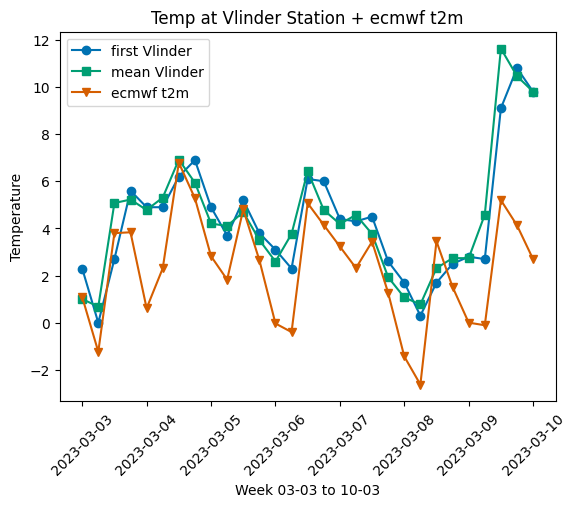

In [3]:
#get the mean value of a given datetime value on temperatures
#target column of forecast dataframe
target = 't2m'
reduced_tmp_forecast = df_fc.groupby('datetime')[target].mean().reset_index()

reduced_tmp_forecast[target] = reduced_tmp_forecast[target] - Const_Conversion[target]

plt.plot(df_vlinder_resampled_first['datetime'], df_vlinder_resampled_first['temp'], marker='o', label='first Vlinder')
plt.plot(df_vlinder_resampled_mean['datetime'], df_vlinder_resampled_mean['temp'], marker='s', label='mean Vlinder')
plt.plot(reduced_tmp_forecast['datetime'], reduced_tmp_forecast[target], marker='v', label=f'ecmwf {target}')
plt.legend(loc='upper left')
plt.xlabel(f"""Week {min_max_date_fc[0].strftime("%d-%m")} to {min_max_date_fc[1].strftime("%d-%m")}""")
plt.ylabel('Temperature')
plt.title(f'Temp at Vlinder Station + ecmwf {target}')
plt.xticks(rotation=45)
plt.show()

We need to decide whether the mean or the first value is the right choice when resampling our Vlinder Data.
We compute correlation between the tmp at the ecmwf station and temp at vlinder station (mean or first)

In [4]:
#Compute Correlation between each metric and the temperatur forecast at station
corr_values = list(map(lambda df : df.corr(reduced_tmp_forecast[target]), df_vlinder_resampled_tmp_metrics))
print(f"correlation: {corr_values}")
#Highest correlated resampled technique
best_resampled_metric_id = corr_values.index(max(corr_values))
print(best_resampled_metric_id)

correlation: [0.7020570620956713, 0.6683605647196877]
0


### 2 Extend Vlinder

In [7]:
#Merge resampled vlinder temperatures into the data frame (use only first)
df_fc_merged = pd.merge(df_fc, df_vlinder_resampled_first, how='left', left_on='datetime', right_on='datetime')
df_fc_merged.rename(columns={'temp': 'temp_vlinder_first'}, inplace=True)

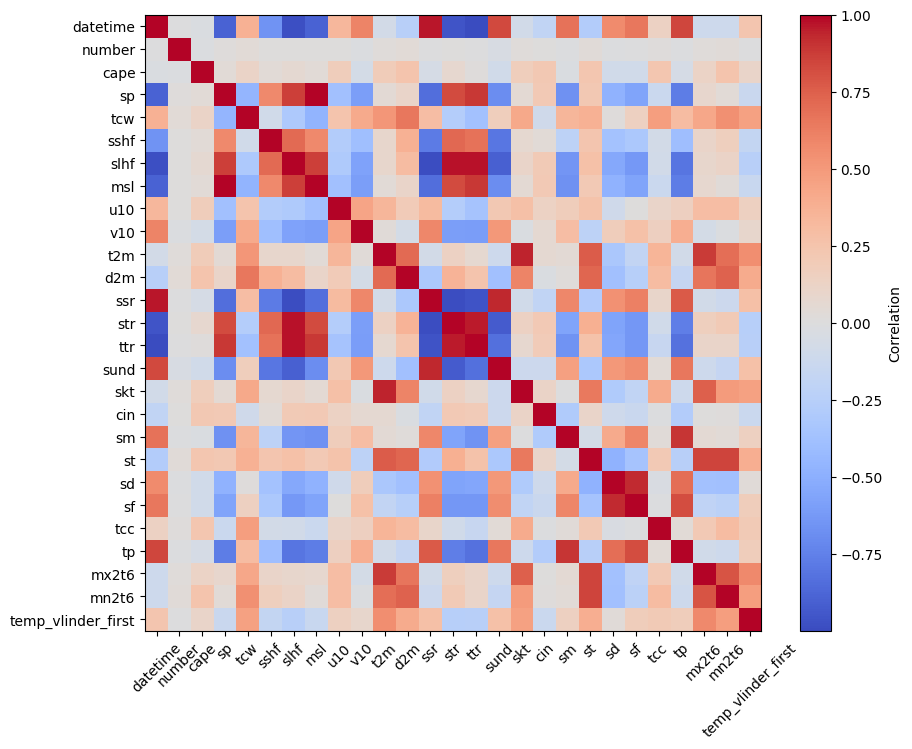

In [8]:
corr_matrix = df_fc_merged.drop(columns=['latitude', 'longitude']).corr() 
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest') 
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.colorbar(label='Correlation')
plt.show()

Before we can start feature selection, we have to split our train and test data